# Metadata

```
Course:   DS 5001
Module:   13 Lab
Topic:    Classification with Perceptron
Author:   R.C. Alvarado
```

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'winereviews'

In [2]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn.linear_model import Perceptron

# Get Data

In [3]:
DOCS = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_DOCS.csv").set_index(['doc_id'])
X_TRAIN = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_TRAIN.csv").set_index(['doc_id'])
X_TEST = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_TEST.csv").set_index(['doc_id'])

# Prepare X and y

In [4]:
y_TRAIN = X_TRAIN.join(DOCS.doc_label).doc_label
y_TEST = X_TEST.join(DOCS.doc_label).doc_label

In [5]:
y_TRAIN.sample(5)

doc_id
65159     N
63628     P
17901     N
108920    N
65374     N
Name: doc_label, dtype: object

In [6]:
y_TEST.sample(5)

doc_id
118970    P
40227     N
109420    N
60781     N
129848    N
Name: doc_label, dtype: object

# Fit Model

In [7]:
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X_TRAIN, y_TRAIN)

Perceptron()

In [8]:
clf.score(X_TRAIN, y_TRAIN) # The mean accuracy against 10% internal validation set

0.9972039473684211

# Test Model

In [9]:
predictions = clf.predict(X_TEST)

In [10]:
y_PREDICT = pd.Series(predictions, index=X_TEST.index)

In [11]:
y_PREDICT.sample(5)

doc_id
84391     N
129848    N
91413     N
102483    P
111448    N
dtype: object

In [12]:
RESULTS = pd.concat([y_TEST, y_PREDICT], axis=1, keys=['actual','prediction'])

In [13]:
RESULTS

,actual,prediction
doc_id,,
31,N,N
35,N,N
44,N,N
51,N,N
66,N,N
...,...,...
129679,P,P
129680,P,P
129681,P,P


In [46]:
RESULTS['result'] = RESULTS.actual == RESULTS.prediction
RESULTS['result_type'] = RESULTS.result.astype('str').str[0] + RESULTS.prediction

In [47]:
RESULTS.sample(10)

,actual,prediction,result,result_type
doc_id,,,,
105321,N,P,False,FP
16006,N,N,True,TN
123922,N,N,True,TN
31636,N,N,True,TN
110753,N,N,True,TN
80957,N,N,True,TN
94772,P,P,True,TP
58393,N,N,True,TN
22728,P,P,True,TP


# Evaluate

In [48]:
RESULTS.result.value_counts()

True     5871
False     257
Name: result, dtype: int64

In [17]:
RESULTS.result_type.value_counts()

TN    3039
TP    2832
FN     134
FP     123
Name: result_type, dtype: int64

In [18]:
RESULTS

,actual,prediction,result,result_type
doc_id,,,,
31,N,N,True,TN
35,N,N,True,TN
44,N,N,True,TN
51,N,N,True,TN
66,N,N,True,TN
...,...,...,...,...
129679,P,P,True,TP
129680,P,P,True,TP
129681,P,P,True,TP


## Confusion Matrix

In [19]:
CM = RESULTS.reset_index().groupby(['prediction','actual']).doc_id.count().unstack().fillna(0)

In [20]:
CM

actual,N,P
prediction,,
N,3039,134
P,123,2832


In [21]:
def show_results(M):
    
    R = M.groupby('result_type').result_type.count().T
    
    print(R)
    print()

    # TP:  hits
    # FP:  Type I errors; false alarms
    # TN:  correct rejections
    # FN:  Type  II errors; misses
    # ACC: Accuracy
    # TPR: True Positive Rate, Recall, Sensitivity
    # TNR: True Negative Rate, Specificity
    # PPV: Positive Predictive Value, Precision
    # BA:  Balanced Accuracy
    # F1:  F-score where F = 1

    T = R.TP + R.TN
    F = R.FP + R.FN
    ALL =  T + F

    ACC = T / ALL
    TPR = R.TP / (R.TP + R.FN)
    TNR = R.TN / (R.TN + R.FP)
    PPV = R.TP / (R.TP + R.FP)
    BA = (TNR + TPR) / 2
    F1 = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN)

    assert ALL == R.sum()

    print('TPR:', round(TPR, 2), '(sensitivity)')
    print('TNR:', round(TNR, 2), '(specificity)')
    print('F1: ', round(F1, 2), '<-- GRADE')
    print('PPV:', round(PPV, 2),  '(precision)')
    print('ACC:', round(ACC, 2), '(accuracy)')        

In [22]:
show_results(RESULTS)

result_type
FN     134
FP     123
TN    3039
TP    2832
Name: result_type, dtype: int64

TPR: 0.95 (sensitivity)
TNR: 0.96 (specificity)
F1:  0.96 <-- GRADE
PPV: 0.96 (precision)
ACC: 0.96 (accuracy)


# Explore

In [23]:
clf.coef_ # Note the two-level array

array([[ -6., -11.,   1., ...,  -3.,  -2.,   1.]])

In [24]:
WEIGHTS = pd.DataFrame({'weight':clf.coef_[0]}, index=X_TRAIN.columns)
WEIGHTS.index.name = 'term_str'

In [25]:
WEIGHTS.sample(10)

,weight
term_str,
ve,0.0
bottled,3.0
peels,-5.0
layering,9.0
mealy,-1.0
glazed,-2.0
cranberry,5.0
varietally,1.0
smoothly,-4.0


## Distribution of Weights

In [26]:
WEIGHTS.weight.describe()

count    3583.000000
mean        2.118337
std         5.459813
min       -23.000000
25%        -1.000000
50%         2.000000
75%         5.000000
max        37.000000
Name: weight, dtype: float64

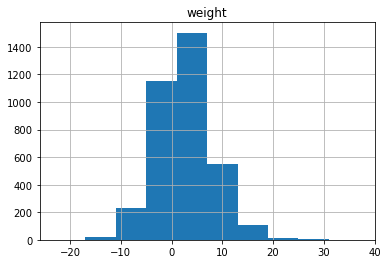

In [27]:
WEIGHTS.hist();

## Top Positive Words

In [28]:
WEIGHTS.sort_values('weight', ascending=False).head(20)

,weight
term_str,
2022,37.0
2030,28.0
exceptional,26.0
2024,26.0
superb,25.0
2025,25.0
memorable,24.0
2021,22.0
gorgeous,21.0


## Top negative words

In [29]:
WEIGHTS.sort_values('weight', ascending=True).head(20)

,weight
term_str,
simple,-23.0
greater,-19.0
lacks,-17.0
montepulciano,-17.0
turns,-15.0
moscato,-15.0
drunk,-15.0
short,-14.0
use,-14.0


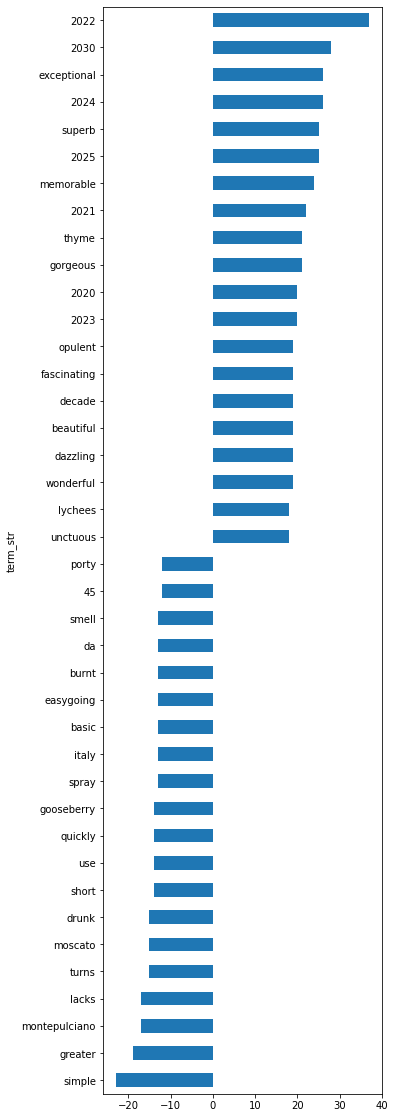

In [30]:
wpos = WEIGHTS.weight.sort_values(ascending=False).head(20)
wneg = WEIGHTS.weight.sort_values(ascending=True).head(20)
pd.concat([wpos,wneg]).sort_values().plot.barh(figsize=(5,20));

In [31]:
WEIGHTS

,weight
term_str,
000,-6.0
04,-11.0
05,1.0
06,-1.0
07,4.0
...,...
zinfandel,-1.0
zing,0.0
zingy,-3.0


# Save

In [58]:
WEIGHTS.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-PERCEPTRON_SALEX.csv')
RESULTS.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-PERCEPTRON_RESULTS.csv')